In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import glob
import tqdm
import time
import yaml
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime
import torch.fft
import torchvision
import torchvision.models as models

from holodecml.torch.tqdm import tqdm

#torch.multiprocessing.set_start_method('spawn')

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

### Load data from disk

In [4]:
class DataLoader(Dataset):
    
    def __init__(self, fn, max_buffer_size = 5000, max_images = 40000, shuffle = True, normalize = True):
        self.fn = fn
        self.buffer = []
        self.max_buffer_size = max_buffer_size
        self.shuffle = shuffle
        self.max_images = max_images
            
        self.fid = open(self.fn, "rb")
        self.loaded = 0 
        self.epoch = 0
        
        self.normalize = normalize
        self.mean = np.mean([0.485, 0.456, 0.406])
        self.std = np.mean([0.229, 0.224, 0.225])
        
    def __getitem__(self, idx):    
        
        self.on_epoch_end()
        
        while True:
        
            try:
                data = joblib.load(self.fid)
                image, label, mask = data
                
                if self.normalize:
                    image /= 255.0
                    image = (image - self.mean) / self.std
                
                #image, label, mask = data
                image = torch.FloatTensor(image)
                label = torch.LongTensor([label])
                #mask = torch.FloatTensor(mask.toarray().squeeze(0))
                
                data = (image, label)#, mask)

                self.loaded += 1

                if not self.shuffle:
                    return data
                
                self.buffer.append(data)
                random.shuffle(self.buffer)

                if len(self.buffer) > self.max_buffer_size:
                    self.buffer = self.buffer[:self.max_buffer_size]

                if self.epoch > 0:
                    return self.buffer.pop()

                else: # wait until all data has been seen before sampling from the buffer
                    return data


            except EOFError:
                self.fid = open(self.fn, "rb")
                self.loaded = 0
                continue
                    
    def __len__(self):
        return self.max_images
    
    def on_epoch_end(self):
        if self.loaded == self.__len__():
            self.fid = open(self.fn, "rb")
            self.loaded = 0
            self.epoch += 1

### Load the binary model 

In [5]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], color_dim = 2, dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv2d(color_dim, 64, (7, 7), (2, 2), (3, 3), bias=False) # Manually change color dim to match our data
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [6]:
with open("models/resnet18_double_duplicate/holo_data.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [7]:
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
data_path = conf["data"]["output_path"]

fn_train = f"{data_path}/training_{tile_size}_{step_size}.pkl"
fn_valid = f"{data_path}/validation_{tile_size}_{step_size}.pkl"

epochs = conf["trainer"]["epochs"]
train_batch_size = conf["trainer"]["train_batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
stopping_patience = conf["trainer"]["stopping_patience"]
model_loc = conf["trainer"]["output_path"]

fcl_layers = conf["resnet"]["fcl_layers"]
dropout = conf["resnet"]["dropout"]
output_size = conf["resnet"]["output_size"]
resnet_model = conf["resnet"]["resnet_model"]
pretrained = conf["resnet"]["pretrained"]

learning_rate = conf["optimizer"]["learning_rate"]
weight_decay = conf["optimizer"]["weight_decay"]

In [8]:
train_dataset = DataLoader(
    fn_train, 
    max_images = int(0.8 * conf["data"]["total_training"]), 
    max_buffer_size = int(0.1 * conf["data"]["total_training"]), 
    shuffle = True, 
    normalize = False
)

test_dataset = DataLoader(
    fn_valid, 
    max_images = int(0.1 * conf["data"]["total_training"]),
    shuffle = False, 
    normalize = False
)

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size, 
    #num_workers=0,
    pin_memory=True,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=valid_batch_size,
    #num_workers=0,
    pin_memory=True,
    shuffle=False)

In [10]:
model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model = resnet_model, 
               pretrained = pretrained).to(device)

In [11]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
trainable_params

11174402

In [13]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

In [14]:
train_criterion = torch.nn.CrossEntropyLoss()
test_criterion = torch.nn.CrossEntropyLoss() 

In [15]:
lr_scheduler = ReduceLROnPlateau(
    optimizer, 
    patience = 1, 
    min_lr = 1.0e-10,
    verbose = True
)

In [16]:
epoch_test_losses = []
results_dict = defaultdict(list)


for epoch in range(epochs):

    ### Train the model 
    model.train()

    batch_loss = []
    accuracy = [] 
        
    # set up a custom tqdm
    batch_group_generator = tqdm(
        enumerate(train_loader), 
        total=batches_per_epoch,
        leave=True
    )
 
    for k, (inputs, y) in batch_group_generator:
        
        # Move data to the GPU, if not there already
        inputs = inputs.to(device).float()
        y = y.to(device).long()
        
        # Clear gradient
        optimizer.zero_grad()

        # get output from the model, given the inputs
        pred_z_logits = model(inputs)

        # get loss for the predicted output
        loss = train_criterion(pred_z_logits, y.squeeze(-1))
        
        # compute the top-1 accuracy
        pred_z_labels = torch.argmax(pred_z_logits, 1)
        accuracy += list((pred_z_labels == y.squeeze(1)).float().detach().cpu().numpy())
        
        # get gradients w.r.t to parameters
        loss.backward()
        batch_loss.append(loss.item())

        # update parameters
        optimizer.step()

        # update tqdm
        to_print = "Epoch {} train_loss: {:.4f}".format(epoch, np.mean(batch_loss))
        to_print += " train_acc: {:.4f}".format(np.mean(accuracy))
        to_print += " lr: {:.12f}".format(optimizer.param_groups[0]['lr'])
        batch_group_generator.set_description(to_print)
        batch_group_generator.update()
                     
        # stop the training epoch when train_batches_per_epoch have been used to update 
        # the weights to the model
        if k >= batches_per_epoch and k > 0:
            break
            
        #lr_scheduler.step(epoch + k / batches_per_epoch)
        
    # Compuate final performance metrics before doing validation
    train_loss = np.mean(batch_loss)
    train_acc = np.mean(accuracy)
        
    # clear the cached memory from the gpu
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    ### Test the model 
    model.eval()
    with torch.no_grad():

        batch_loss = []
        accuracy = []
        
        # set up a custom tqdm
        batch_group_generator = tqdm(
            enumerate(test_loader),
            leave=True
        )

        for k, (inputs, y) in batch_group_generator:
            # Move data to the GPU, if not there already
            inputs = inputs.to(device).float()
            y = y.to(device).long()
            # get output from the model, given the inputs
            pred_z_logits = model(inputs)
            # get loss for the predicted output
            loss = test_criterion(pred_z_logits, y.squeeze(-1))
            batch_loss.append(loss.item())
            # compute the accuracy
            pred_z_labels = torch.argmax(pred_z_logits, 1)
            accuracy += list((pred_z_labels == y.squeeze(1)).float().detach().cpu().numpy())
            # update tqdm
            to_print = "Epoch {} test_loss: {:.4f}".format(epoch, np.mean(batch_loss))
            to_print += " test_acc: {:.4f}".format(np.mean(accuracy))
            batch_group_generator.set_description(to_print)
            batch_group_generator.update()

    # Use the accuracy as the performance metric to toggle learning rate and early stopping
    test_loss = 1 - np.mean(accuracy)
    epoch_test_losses.append(test_loss)
    
    # Lower the learning rate if we are not improving
    lr_scheduler.step(test_loss)

    # Save the model if its the best so far.
    if test_loss == min(epoch_test_losses):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss
        }
        torch.save(state_dict, f"{model_loc}/best.pt")
        
    # Get the last learning rate
    learning_rate = optimizer.param_groups[0]['lr']
        
    # Put things into a results dictionary -> dataframe
    results_dict['epoch'].append(epoch)
    results_dict['train_loss'].append(train_loss)
    results_dict['valid_loss'].append(np.mean(batch_loss))
    results_dict['train_accuracy'].append(train_acc)
    results_dict['valid_accuracy'].append(np.mean(accuracy))
    results_dict["learning_rate"].append(learning_rate)
    df = pd.DataFrame.from_dict(results_dict).reset_index()

    # Save the dataframe to disk
    df.to_csv(f"{model_loc}/training_log.csv", index = False)
        
    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(epoch_test_losses) if j == min(epoch_test_losses)][0]
    offset = epoch - best_epoch
    if offset >= stopping_patience:
        break
        
    if results_dict['valid_accuracy'][-1] == 1.0:
        break

  0%|          | 0/200 [00:03<?, ?it/s]


KeyboardInterrupt: 

### Load the best model

In [57]:
with open("models/resnet18_double_duplicate/holo_data.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [58]:
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
data_path = conf["data"]["output_path"]

fn_train = f"{data_path}/training_{tile_size}_{step_size}.pkl"
fn_valid = f"{data_path}/validation_{tile_size}_{step_size}.pkl"

epochs = conf["trainer"]["epochs"]
train_batch_size = conf["trainer"]["train_batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
stopping_patience = conf["trainer"]["stopping_patience"]
model_loc = conf["trainer"]["output_path"]

fcl_layers = conf["resnet"]["fcl_layers"]
dropout = conf["resnet"]["dropout"]
output_size = conf["resnet"]["output_size"]
resnet_model = conf["resnet"]["resnet_model"]
pretrained = conf["resnet"]["pretrained"]

learning_rate = conf["optimizer"]["learning_rate"]
weight_decay = conf["optimizer"]["weight_decay"]

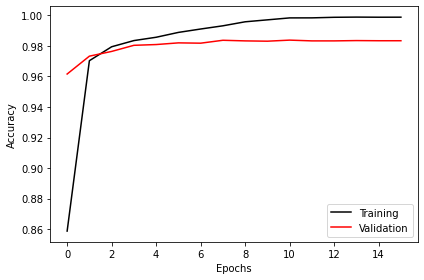

In [59]:
f = pd.read_csv(f"{model_loc}/training_log.csv")
plt.plot(f["epoch"], f["train_accuracy"], c = 'k')
plt.plot(f["epoch"], f["valid_accuracy"], c = 'r')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc = "best")

plt.tight_layout()

In [60]:
model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = pretrained).to(device)

checkpoint = torch.load(
    f"{model_loc}/best.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()

ResNet(
  (resnet): Sequential(
    (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

### Predict on the validation data set

In [61]:
valid_batch_size = 128
buffer_size = valid_batch_size

batch_loss = []
accuracy = []

truths = []
preds = []
probs = []

epoch = checkpoint["epoch"]

# set up a custom tqdm
batch_group_generator = tqdm(
    enumerate(test_loader),
    leave=True
)

test_criterion = torch.nn.CrossEntropyLoss() 

with torch.no_grad():
    for k, (inputs, y) in batch_group_generator:
        # get output from the model, given the inputs
        inputs = inputs.to(device)
        y = y.to(device)
        pred_z_logits = model(inputs)
        # get loss for the predicted output
        loss = test_criterion(pred_z_logits, y.squeeze(-1))
        batch_loss.append(loss.item())
        # compute the accuracy
        pred_z_labels = torch.argmax(pred_z_logits, 1)
        accuracy += list((pred_z_labels == y.squeeze(1)).float().detach().cpu().numpy())

        truths.append(y.squeeze(1).float().detach().cpu().numpy())
        preds.append(pred_z_labels.float().detach().cpu().numpy())

        pred_prob = np.max(pred_z_logits.exp().detach().cpu().numpy(), 1)
        probs.append(pred_prob)

        # update tqdm
        to_print = "Epoch {} test_loss: {:.4f}".format(epoch, np.mean(batch_loss))
        to_print += " test_acc: {:.4f}".format(np.mean(accuracy))
        batch_group_generator.set_description(to_print)
        batch_group_generator.update()
    
truths = np.hstack(truths)
preds = np.hstack(preds)
probs = np.hstack(probs)

Epoch 10 test_loss: 0.0623 test_acc: 0.9846: : 40it [00:28,  1.40it/s]


### Compute the confusion matrix

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [63]:
cm = confusion_matrix(truths, preds, normalize = 'true')
tn, fp, fn, tp = cm.ravel()

In [64]:
df_cm = pd.DataFrame(cm, index = sorted(list(set(preds))), columns = sorted(list(set(preds))))

In [65]:
df_cm

,0.0,1.0
0.0,0.9796,0.0204
1.0,0.0104,0.9896


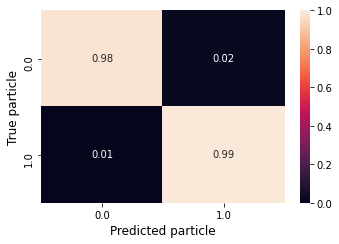

In [66]:
plt.figure(figsize = (5,3.5))
sn.heatmap(df_cm, annot=cm, vmin = 0, vmax = 1)
plt.xlabel("Predicted particle", fontsize = 12)
plt.ylabel("True particle", fontsize = 12)

plt.tight_layout()

plt.savefig(f'{model_loc}/confusion_matrix.pdf', dpi = 300)

### Compute a confidence threshold on label 1 predictions

In [44]:
df = defaultdict(list)

for yt, yp, ypp in zip(truths, preds, probs):
    df["y_true"].append(yt)
    df["y_pred"].append(yp)
    df["y_conf"].append(ypp)
    df["acc"].append(int(yt==yp))
    
df = pd.DataFrame.from_dict(df)

In [51]:
ACCURACY = 0.995

c = (df["y_true"] >= 1)
df = df[c].copy()

# sort df by prediction probability, greatest to least
df = df.sort_values(f"y_conf", ascending=False)

# compute the cumulative accuracy 
df["dummy"] = 1
df["correct"] = df["y_true"] == df["y_pred"]
df["accuracy"] = df["correct"].cumsum() / df["dummy"].cumsum()
df["coverage"] = df["dummy"].cumsum() / len(df)

thresh = df[df.accuracy>=ACCURACY]
conf = thresh[f"y_conf"].min()
cv = thresh["coverage"].max()

Text(0, 0.5, 'Accuracy')

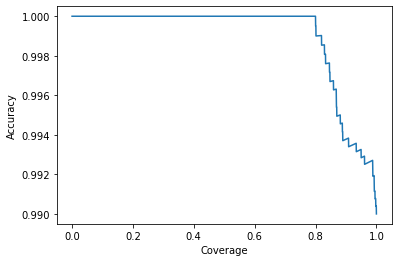

In [52]:
plt.plot(df.coverage.values, df.accuracy.values)
plt.xlabel("Coverage")
plt.ylabel("Accuracy")

In [53]:
conf

0.985430121421814

### Performance diagram

In [54]:
from hagelslag.evaluation.ProbabilityMetrics import *
from hagelslag.evaluation.MetricPlotter import *

In [55]:
obs_threshold = 1.0
thresholds = 1.0 - np.logspace(-5, 0, num=100, endpoint=True, base=10.0, dtype=None, axis=0)
thresholds = thresholds[::-1]

In [56]:
#thresholds = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])

roc = DistributedROC(thresholds=thresholds, obs_threshold=1.0)

roc.update(probs.ravel(), truths.ravel())

In [57]:
roc.max_threshold_score()

(0.9966483973490612, 0.5586034912718204)

In [58]:
roc.max_csi()

0.7210401891252955

In [60]:
roc_curve([roc], ["ResNet-18"], ["orange"], ["o"], f"{model_loc}/roc_training.png")

In [61]:
performance_diagram([roc], ["ResNet-18"], ["orange"], ["o"], f"{model_loc}/performance_training.png")

In [62]:
with open(f"{model_loc}/roc_training.pkl", "wb") as fid:
    joblib.dump(roc, fid)